### Analysis of South Park transcripts

<img src="https://forbes.hu/wp-content/uploads/2021/08/southpark2_forbes.jpg" width="1000"/>


In [1]:
import sys 
sys.path.append('../../')
from src.import_packages import *

Importing the following packages: pandas, numpy, matplotlib, seaborn, plotly, warnings


In [200]:
data = pd.read_csv('data/transcript_cleaned.csv')
data.head(3)

,speaker,line,season,episode_num,episode_title,speaking_to,line_clean
0,Other,"School days, school days, teacher's golden ru...",1,1,Cartman Gets an Anal Probe,Kyle,school day school day teacher golden ru
1,Kyle,"Ah, damn it! My little brother's trying to fol...",1,1,Cartman Gets an Anal Probe,Other,ah damn little brother trying follow school
2,Other,Eat banana.,1,1,Cartman Gets an Anal Probe,Kyle,eat banana


### Line count overall and by seasons

In [201]:
df = data.loc[data['speaker'] != 'Other']

In [202]:
overall_line_count = df.groupby('speaker').agg({'line' : 'count'}).reset_index().sort_values('line', ascending = True).rename(columns = {'line' : '# of lines'})

fig = px.bar(overall_line_count, '# of lines', 'speaker',
              title = 'Total lines throughout whole series', 
              labels = {'speaker' : ''},
              width = 1250, height = 750)
fig.update_yaxes(tickfont = {'size' : 15})
fig.show()

Top 10 speakers by season

In [203]:
line_count_by_season = df.groupby(['season', 'speaker']).agg({'line' : 'count'}).reset_index().sort_values(['season', 'line'], ascending = [True, False]).rename(columns = {'line' : '# of lines'})
line_count_by_season = line_count_by_season.groupby('season').head(10)

In [204]:
fig = px.bar(line_count_by_season.sort_values(['season', '# of lines']), '# of lines', 'speaker', facet_col='season', facet_col_wrap=6, facet_col_spacing=0.05,
              title = 'Top 10 lines per season', 
              labels = {'speaker' : ''},
              width = 1550, height = 950)
fig.update_yaxes(tickfont = {'size' : 11}, matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.update_xaxes(matches=None)
fig.show()

Show heatmap of lines per season

In [205]:
# sns.set(rc={"figure.dpi":150, 'savefig.dpi':200})
# sns.set(font_scale=0.5)
%config InlineBackend.figure_format = 'svg'

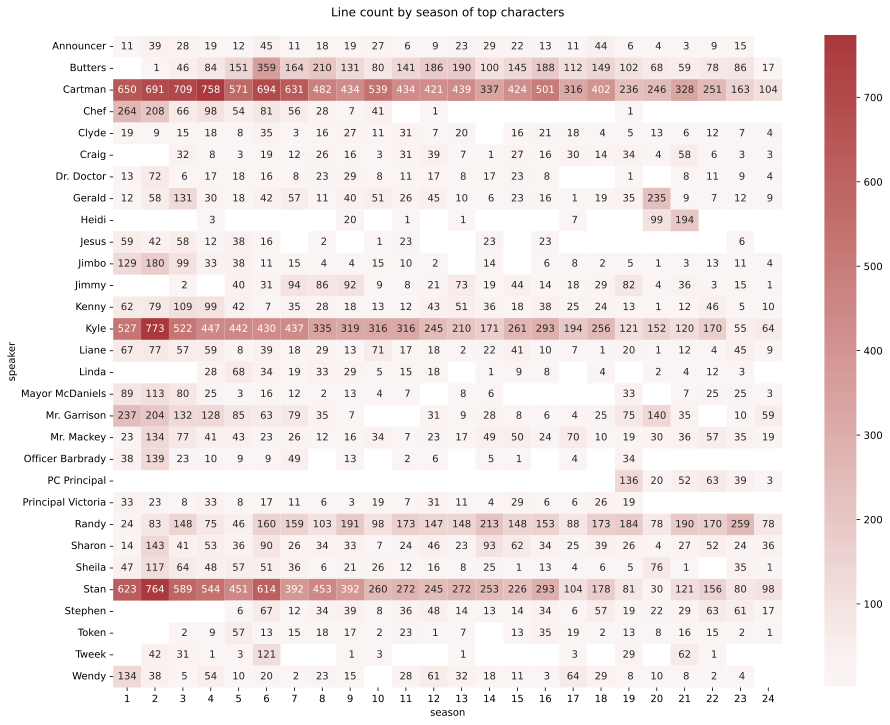

In [206]:
line_count_by_season_heatmap = df.groupby(['season', 'speaker']).agg({'line' : 'count'}).reset_index().sort_values(['season', 'line'], ascending = [True, False]).rename(columns = {'line' : '# of lines'})
line_count_by_season_heatmap = line_count_by_season_heatmap.pivot_table(index = 'speaker', columns = 'season', values = '# of lines').fillna(0).astype(int).reset_index()

fig, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(line_count_by_season_heatmap.set_index('speaker').replace(0, np.nan), 
            ax = ax, cmap = 'vlag', annot = True, fmt = '2g', center = 0)
plt.title('Line count by season of top characters\n')
plt.yticks(va = 'center', rotation = 0)
plt.show()

Show heatmap of avg line count per episode per season

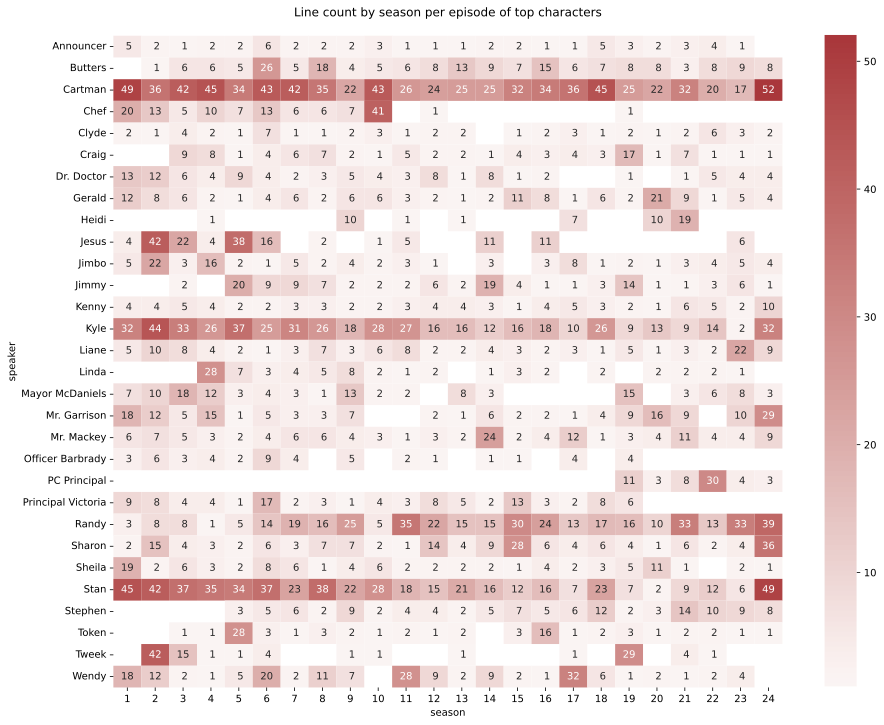

In [207]:
line_count_by_season_heatmap_avg = df.groupby(['speaker', 'season', 'episode_num']).agg({'line' : 'count'}).reset_index().groupby(['speaker', 'season']).agg({'line' : 'median'}).reset_index()
line_count_by_season_heatmap_avg = line_count_by_season_heatmap_avg.pivot_table(index = 'speaker', columns = 'season', values = 'line').fillna(0).astype(int).reset_index()

fig, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(line_count_by_season_heatmap_avg.set_index('speaker').replace(0, np.nan), 
            ax = ax, cmap = 'vlag', annot = True, fmt = '2g', center = 0)
plt.title('Line count by season per episode of top characters\n')
plt.yticks(va = 'center', rotation = 0)
plt.show()

### Top words per speaker

In [208]:
import re
from nltk.util import ngrams
from nltk.collections import Counter

In [209]:
documents = df['speaker'].unique().tolist()
grams_dfs_N = {}
Ns = [1, 2, 3]

for N in Ns:
    
    ngram_col_name = 'ngram_' + str(N)
    grams_dfs = {}

    for speaker in documents:

        transcript = re.compile('\s+').sub(' ', ' '.join(df[df['speaker'] == speaker]['line_clean']))
        count_grams = Counter(ngrams(transcript.split(' '), N))
        count_grams_df = pd.DataFrame.from_dict(count_grams, orient = 'index')\
                                     .reset_index().sort_values(0, ascending = False).reset_index(drop = True)\
                                     .rename(columns = {'index' : ngram_col_name, 0 : 'count'})
        if N != 1:
            
            count_grams_df['check_repetitions'] = count_grams_df[ngram_col_name].apply(lambda x: 1 if len(set(x)) == 1 else 0)
            count_grams_df = count_grams_df[count_grams_df['check_repetitions'] == 0]
            count_grams_df.drop('check_repetitions', 1, inplace = True)
            count_grams_df.reset_index(drop = True, inplace = True)
            
        count_grams_df[ngram_col_name] = count_grams_df[ngram_col_name].apply(lambda x: ' '.join(x))

        grams_dfs[speaker] = count_grams_df
        
    grams_dfs = pd.concat(grams_dfs, axis = 0, ignore_index = False)\
                    .reset_index()\
                    .drop('level_1', 1)\
                    .rename(columns = {'level_0' : 'speaker'})
    grams_dfs_N[N] = grams_dfs

In [210]:
print(len(grams_dfs_N) == len(Ns))

True


In [211]:
def ngram_plots(ngram_number = 1, row_spacing = .05, col_spacing = .05, width = 1450, height = 1550, col_wrap = 5, ticksize = 12):
    
    ngram_col_name = 'ngram_' + str(ngram_number)
    
    fig = px.bar(grams_dfs_N[ngram_number].groupby('speaker').head(10).sort_values(['speaker', 'count']), 'count', ngram_col_name, facet_col='speaker', 
             facet_col_wrap=col_wrap, facet_row_spacing=row_spacing, facet_col_spacing=col_spacing,
              title = 'Top ngrams (' + str(ngram_number) + ') by characters',
              labels = {ngram_col_name : ''}, width = width, height = height)
    fig.update_xaxes(showticklabels = True, matches = None)
    fig.update_yaxes(showticklabels=True, matches = None, tickfont = {'size' : ticksize})
    fig.for_each_annotation(lambda a: a.update(text = a.text.split('=')[-1]))
    fig.update_layout(showlegend = False)
    fig.show()

In [212]:
ngram_plots()

In [213]:
ngram_plots(2, col_wrap=4, col_spacing=0.075, height=2550, ticksize=15)

In [214]:
ngram_plots(3, col_wrap=4, col_spacing=0.15, height=2550, ticksize=15)

### Top tf-idf per speaker

In [215]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [216]:
documents = df['speaker'].unique().tolist()
words = []

for speaker in documents:
    words.append(' '.join(df[df['speaker'] == speaker]['line_clean']))
    
vectorizer = TfidfVectorizer(max_df=.5, min_df = 1, norm = None)
transformed_documents = vectorizer.fit_transform(words)

transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array) == len(documents)

True

In [217]:
# https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf#how-the-algorithm-works

tfidf_by_speakers = []

for counter, doc in enumerate(transformed_documents_as_array):
    
    speaker = documents[counter]    
    score_col_name = 'score' 
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['word', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    one_doc_as_df['speaker'] = speaker
    
    tfidf_by_speakers.append(one_doc_as_df)
    
tfidf_data = pd.concat(tfidf_by_speakers, axis = 0)
tfidf_data.sort_values(['speaker', 'score'], ascending = [True, False], inplace = True)
#tfidf_data.columns = tfidf_data.columns.droplevel()

In [218]:
tfidf_data_plot = tfidf_data.groupby('speaker').head(10).sort_values(['speaker', 'score'])

In [219]:
def plot_tfidf_data(data, row_spacing = .03, col_spacing = .1, width = 950, height = 950, col_wrap = 3, ticksize = 10):
    
    fig = px.bar(data, 'score', 'word', facet_col='speaker', 
             facet_col_wrap=col_wrap, facet_row_spacing=row_spacing, facet_col_spacing=col_spacing,
              title = 'Top characters most personal words (TF-IDF)',
              labels = {'score' : 'Tf-Idf value', 'word' : ''}, width = width, height = height)
    fig.update_xaxes(showticklabels = True, matches = None)
    fig.update_yaxes(showticklabels=True, matches = None, tickfont = {'size' : ticksize})
    fig.for_each_annotation(lambda a: a.update(text = a.text.split('=')[-1]))
    fig.update_layout(showlegend = False)
    fig.show()

In [220]:
plot_tfidf_data(tfidf_data_plot, col_wrap=4, col_spacing=0.075, height=2550, ticksize=15, width = 1450)

### To-From network

In [221]:
df = df[df['speaking_to'] != 'Other']
from_to_counts = df[['speaker', 'speaking_to']].value_counts().reset_index().rename(columns = {0 : 'weight'})

In [222]:
import networkx as nx
from pyvis.network import Network
from IPython.display import Image, display


def plot_conversation_network(from_to_data, edge_divider = 125,
                              k = 6, size = (16, 9), node_size_power = 0.85):
    
    np.random.seed(12)
    nodes = from_to_data.groupby('speaker')['weight'].sum()

    G = nx.from_pandas_edgelist(from_to_data, source = 'speaker', target = 'speaking_to', 
                                edge_attr = 'weight', create_using = nx.Graph())

    node_sizes = nodes[[i for i in G.nodes]]

    line_widths = [i['weight'] / edge_divider for i in dict(G.edges).values()]
    labels = {i:i for i in dict(G.nodes).keys()}

    plt.figure(figsize = size) 

    pos = nx.fruchterman_reingold_layout(G, k = k)
    nx.draw_networkx_nodes(G, pos = pos, node_size = np.power(node_sizes, node_size_power), 
                           node_color = 'lightgray', edgecolors = 'gray', alpha = 1) 
    nx.draw_networkx_edges(G, pos = pos, width = line_widths, edge_color = 'black', alpha = 1/2)
    nx.draw_networkx_labels(G, pos = pos, font_size = 10)

    plt.box(False)
    plt.show()

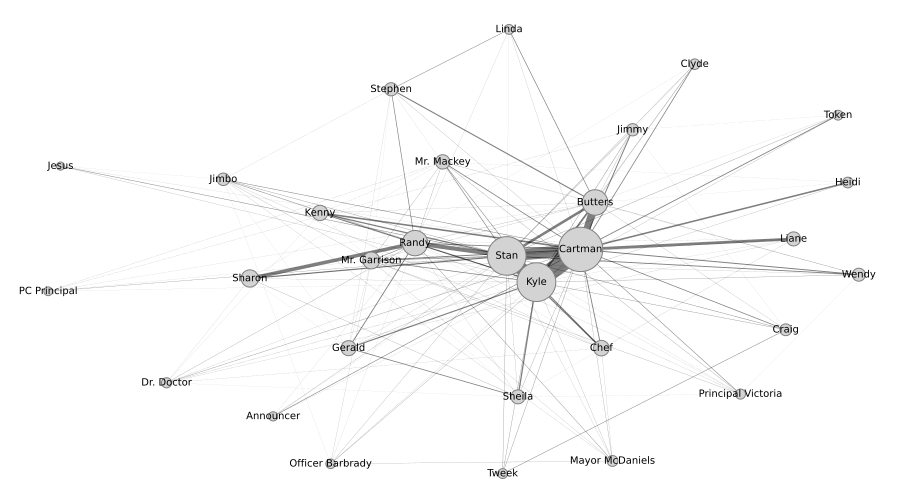

In [223]:
plot_conversation_network(from_to_counts)

### Profanity counter

In [224]:
def Occ_word_per_lines(swear_word = 'fuck'):

    prof_word_relative = df.groupby('speaker').apply(lambda x: ' '.join(x['line_clean'])).str.count(swear_word) / df.groupby('speaker')['line_clean'].count() * 1000
    prof_word_relative = prof_word_relative.sort_values()

    fig = px.bar(prof_word_relative, orientation='h', title = 'Occurence of word "' + swear_word + '" per 1000 lines spoken', width = 1250, height = 750)
    fig.update_xaxes(showticklabels = True)
    fig.update_yaxes(showticklabels=True, tickfont = {'size' : 15})
    fig.update_layout(showlegend = False)
    fig.show()

In [225]:
Occ_word_per_lines()

In [226]:
Occ_word_per_lines('bitch')

In [227]:
Occ_word_per_lines('shit')

In [228]:
Occ_word_per_lines('jew')

In [229]:
def Occ_word_per_words(swear_word = 'fuck'):

    prof_word_relative = df.groupby('speaker').apply(lambda x: ' '.join(x['line_clean'])).str.count(swear_word) / df.groupby('speaker').apply(lambda x: len(' '.join(x['line_clean']).split()))* 1000
    prof_word_relative = prof_word_relative.sort_values()

    fig = px.bar(prof_word_relative, orientation='h', title = 'Occurence of word "' + swear_word + '" per 1000 words spoken', width = 1250, height = 750)
    fig.update_xaxes(showticklabels = True)
    fig.update_yaxes(showticklabels=True, tickfont = {'size' : 15})
    fig.update_layout(showlegend = False)
    fig.show()

In [230]:
Occ_word_per_words()

In [231]:
Occ_word_per_words('shit')

#### All profanities counted per speaker

In [232]:
swear_words = open('data/swear_words.txt', 'r').read().split()

def Occ_word_per_words(swear_word_list = ('fuck', 'bitch', 'damn')):

    prof_word_relative = df.groupby('speaker').apply(lambda x: sum(map(' '.join(x['line_clean']).count, swear_word_list))) / df.groupby('speaker').apply(lambda x: len(' '.join(x['line_clean']).split()))* 1000
    prof_word_relative = prof_word_relative.sort_values()

    fig = px.bar(prof_word_relative, orientation='h', title = 'Occurence of any swearwords, profanities per 1000 words spoken', width = 1250, height = 750)
    fig.update_xaxes(showticklabels = True)
    fig.update_yaxes(showticklabels=True, tickfont = {'size' : 15})
    fig.update_layout(showlegend = False)
    fig.show()

In [233]:
Occ_word_per_words(swear_words)

#### Profanities per season

In [249]:
# two rows are messing up the chart (hell and pissed are deleted)

df.loc[(df['speaker'] == 'Heidi') & (df['season'] == 4), 'line_clean'] = ''
df.loc[(df['speaker'] == 'Token') & (df['season'] == 12), 'line_clean'] = ''

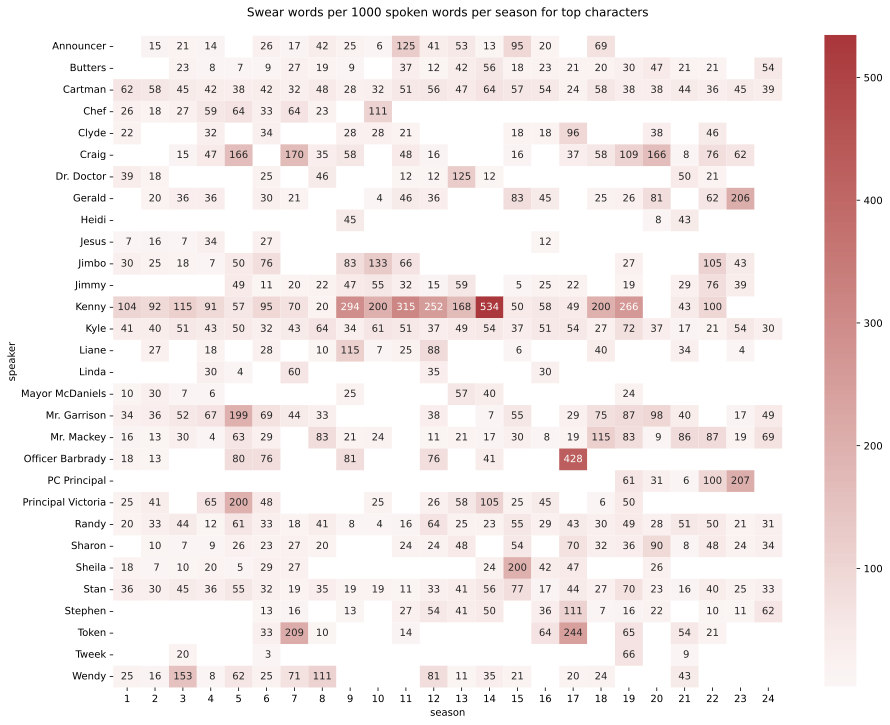

In [250]:
profan_per_season = df.groupby(['season', 'speaker']).apply(lambda x: sum(map(' '.join(x['line_clean']).count, swear_words))) / df.groupby(['season', 'speaker']).apply(lambda x: len(' '.join(x['line_clean']).split())) * 1000
profan_per_season = profan_per_season.reset_index().pivot_table(index = 'speaker', columns = 'season', values = 0).fillna(0).astype(int)

fig, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(profan_per_season.replace(0, np.nan), 
            ax = ax, cmap = 'vlag', annot = True, fmt = '2g', center = 0)
plt.title('Swear words per 1000 spoken words per season for top characters\n')
plt.yticks(va = 'center', rotation = 0)
plt.show()

## Sentiment analysis

In [253]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader_sentiment = SentimentIntensityAnalyzer()

def vader_sentiment_scores(x):
    scores = vader_sentiment.polarity_scores(x)
    return scores['neg'], scores['neu'], scores['pos'], scores['compound']

In [256]:
sentiment_data = df.copy()
sentiment_data[['neg', 'neu', 'pos', 'compound_score']] = sentiment_data.apply(lambda x: vader_sentiment_scores(str(x['line_clean'])), result_type ='expand', axis = 1)

In [275]:
polarity_by_people = sentiment_data.groupby(['speaker'])[['neg', 'pos', 'compound_score']].mean().sort_values('neg')
polarity_by_people['neu'] = 1 - polarity_by_people['neg'] - polarity_by_people['pos']
polarity_bar_plot = polarity_by_people.reset_index().melt(id_vars = ['speaker', 'compound_score'], value_vars = ['neg', 'neu', 'pos'])

In [276]:
def plot_polarity_ratios(data, row_spacing = .05, col_spacing = .1, width = 1050, col_wrap = 3):
    
    fig = px.bar(data, 'value', 'speaker', color = 'variable',
                 color_discrete_map={'neg' : 'indianred', 'neu' : 'lightyellow', 'pos' : 'lightgreen'},
              title = 'Ratio of types of sentiments by characters',
              labels = {'speaker' : 'Speaker', 'value' : 'Sentiment polarity'}, width = width, height = 750)
    fig.update_xaxes(showticklabels = True)
    fig.update_yaxes(showticklabels=True)
    fig.update_layout(showlegend = False)
    fig.show()

In [277]:
plot_polarity_ratios(polarity_bar_plot)

## Similarly talking people, similar episodes based on transcript

In [289]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.decomposition import PCA

In [283]:
df = df[df['line_clean'] != '']

In [328]:
embed_data = df.groupby(['season','episode_num', 'episode_title'])['line'].apply(lambda x: ' '.join(x)).reset_index()
embed_data.rename(columns = {'line' : 'episode_transcript'}, inplace = True)

Get Universal Sentence Encoder from Google

In [294]:
import os
os.environ['TFHUB_CACHE_DIR'] = '../southpark/data/cache'

In [295]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
model = hub.load(module_url)

Encode episode transcripts as vectors

In [329]:
%%time

sentence_vectors = model(embed_data['episode_transcript'].values)
sentence_vectors_df = pd.DataFrame(np.array(sentence_vectors))

Wall time: 18.1 s


Dimensionality reduction for visualization

In [330]:
pca = PCA(n_components = 5, random_state = 20202020)
sentence_vectors_reduced = pca.fit_transform(sentence_vectors_df)

In [331]:
embed_data[['vector_dim_1', 'vector_dim_2', 'vector_dim_3', 'vector_dim_4', 'vector_dim_5']] = sentence_vectors_reduced

In [332]:
def plot_episode_vectors(data, x = 'vector_dim_1', y = 'vector_dim_2', color = 'season', hover_data = ['season', 'episode_num', 'episode_title'],  title = 'Episode similarity based on transcript embedding vectors'):
    
    fig = px.scatter(data, x = x, y = y, color = color, color_continuous_scale='solar',
                 hover_data = hover_data, title = title, 
                     labels = {'season' : 'Season', 'episode_num' : 'Episode #', 'vector_dim_1' : '1st principal component', 'vector_dim_2' : '2nd principal component'},
                     width = 1250, height = 750)
    fig.update_traces(marker={'size' : 10, 'opacity' : 1, 'line' : {'width' : 1, 'color' : 'black'}})
    fig.show()

In [333]:
plot_episode_vectors(embed_data)

#### Similarly talking people

In [334]:
embed_data_char = df.groupby(['speaker'])['line'].apply(lambda x: ' '.join(x)).reset_index()
embed_data_char.rename(columns = {'line' : 'speech'}, inplace = True)

sentence_vectors_char = model(embed_data_char['speech'].values)
sentence_vectors_char_df = pd.DataFrame(np.array(sentence_vectors_char))

pca = PCA(n_components = 2, random_state = 42)
sentence_vectors_char_reduced = pca.fit_transform(sentence_vectors_char_df)

embed_data_char[['vector_dim_1', 'vector_dim_2']] = sentence_vectors_char_reduced

In [335]:
plot_episode_vectors(embed_data_char, hover_data = ['speaker'], color = None)